Github: https://github.com/Sammat2507/proyecto-sprint-9

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score, roc_auc_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
bank = pd.read_csv('Churn.csv')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
bank = bank.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
bank = pd.get_dummies(bank, columns=['Geography', 'Gender'], drop_first=True)
bank = bank.fillna(0)
bank = bank.astype(int)
print(bank)

      CreditScore  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0             619   42       2        0              1          1   
1             608   41       1    83807              1          0   
2             502   42       8   159660              3          1   
3             699   39       1        0              2          0   
4             850   43       2   125510              1          1   
...           ...  ...     ...      ...            ...        ...   
9995          771   39       5        0              2          1   
9996          516   35      10    57369              1          1   
9997          709   36       7        0              1          0   
9998          772   42       3    75075              2          1   
9999          792   28       0   130142              1          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0                  1           101348       1                  0   
1                  1           1125

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


<Axes: xlabel='Exited'>

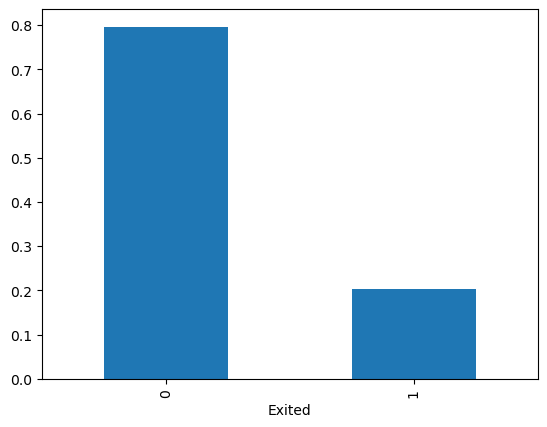

In [4]:
target = bank['Exited']
features = bank.drop('Exited', axis=1)
class_frequency = target.value_counts(normalize=True)
train_features, test_features, train_target, test_target =  train_test_split(features, target, test_size=0.2, random_state=12345)
train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, test_size=0.25, random_state=12345)
print(class_frequency)
class_frequency.plot(kind='bar')

- Tenemos un desequilibrio ya que los datos en un 80% de los casos son 0. Esto puede hacer que el modelo no aprenda a predecir los casos en los que la respuesta correcta es 1, por esto coincidero que debemos j¿hacer un sobre muestreo o submuestreo para equilibrarlo.

In [5]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_valid_upsampled, target_valid_upsampled = upsample(valid_features, valid_target, 4)
features_train_upsampled, target_train_upsampled = upsample(train_features, train_target, 4)
print(target_valid_upsampled.value_counts(normalize=True))

Exited
0    0.507091
1    0.492909
Name: proportion, dtype: float64


In [6]:
#best_score = 0.59
#best_depth = 0
#for depth in range(1, 16, 1): 
#    model_forest = RandomForestClassifier(random_state=54321, max_depth=depth, n_estimators=20) 
#    model_forest.fit(features_train_upsampled, target_train_upsampled) 
#    predictions_forest = model_forest.predict(features_valid_upsampled)
#    score = f1_score(target_valid_upsampled, predictions_forest) 
#    if score > best_score:
#        best_score = score
#        best_depth = depth
#        print(best_depth)
#        print(best_score)

- Con este loop averigue los mejores hiperparametros.

In [7]:
model_forest = RandomForestClassifier(random_state=54321, max_depth=6, n_estimators=100, class_weight='balanced') 
model_forest.fit(features_train_upsampled, target_train_upsampled) 
predictions_forest = model_forest.predict(features_valid_upsampled)
score_forest = f1_score(target_valid_upsampled, predictions_forest)
print(score_forest)

0.7321850726106045


- La otra opcion que tenemos para solucionar el problema del desequilibrio de clases es utilizar el argumento class_weight para equilibrar el peso de cada clase y asi el modelo pueda ser entrenado bien.

In [8]:
model_logistic = LogisticRegression(random_state=12345, solver='liblinear')
model_logistic.fit(features_train_upsampled, target_train_upsampled)
predictions_logistic = model_logistic.predict(features_valid_upsampled)
score_logistic = f1_score(target_valid_upsampled, predictions_logistic)
print(score_logistic)

0.6711906230721777


In [9]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train_upsampled, target_train_upsampled)
predictions_tree = model_tree.predict(features_valid_upsampled)
score_tree = f1_score(target_valid_upsampled, predictions_tree)
print(score_tree)

0.5737439222042139


In [10]:
model_forest_test_predictions = model_forest.predict(test_features)
model_forest_test_score = f1_score(test_target, model_forest_test_predictions)
print(model_forest_test_score)

0.6288461538461538


- El mejor modelo de clasificacion teniendo en cuenta el f1_score es el randomforestclassifier, esto debido a que con el conjunto de validacion tiene un score de 0.72 y con el de prueba tiene 0.61 superando el objetivo

In [11]:
test_probabilities = model_forest.predict_proba(test_features)[:, 1]
test_auc_roc = roc_auc_score(test_target, test_probabilities)
print(test_auc_roc)

0.8664896951037041


- Es mayor el valor auc roc que el f1. Esto significa que el modelo sabe discriminar entre las diferentes clases pero no es tan bueno con la precision y el recall lo que podria mejorarse ajustando el umbral.